In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def rank_list_values(li):
  copied = sorted(li, reverse=True)
  res = [0 for i in range(len(li))]

  i = 0
  while sum([1 if x >= 0 else 0 for x in li]) > 0:
    val = copied[i]
    original_i = li.index(val)
    res[original_i] = i + 1
    li[original_i] = -1
    i += 1

  return res

def hits(matrix, k=10, beta=0.85):
  #This is the main function. it gets a generated matrix and uses the HITS algorithm to calculate the scores
  hub_vector = np.ones([len(matrix), 1])
  transpose = np.transpose(matrix)

  for i in range(k):
    authority_vector = np.matmul(transpose, hub_vector) * beta
    authority_vector /= np.sum(authority_vector)

    hub_vector = np.matmul(matrix, authority_vector) * beta
    hub_vector /= np.sum(hub_vector)

  added = np.add(authority_vector, hub_vector).flatten().tolist()
  ranked = rank_list_values(added)
  return ranked

To create our spamfarm we:
  1. create our matrix of in accesible pages. This wil be a matrix of n x n with ones in random places to represent links.
  2. This matrix will be extended with our accesible page that Links the spammer page T.
  3. the matrix wi

In [ ]:
# f=supporting pages, n=inaccesable web pages, ap=accesible pages
def gen_spam_matrix(f, n, ap, labels=False):
  # create the row for the target page, this one links to all the supporting pages
  t = np.concatenate((np.array([0]),np.ones([f]),np.zeros([n + ap])), axis=0)
  # create the row for a supporting page with only the link to the target page this can be copied of f times as all the pages only link the target page
  f_page = np.concatenate(([1],np.zeros([f]),np.zeros([n + ap])), axis=0)
  f_all = np.tile(f_page, (f,1))
  matrix = np.append([t],f_all, axis=0)
  # generate the rows for the inaccesable pages and for the accesible page. These will be zero for target page and the supporting pages but at random can link eachother. The accesible with have a link to the target page
  for i in range(n + ap):
    amount_of_ones = int(np.random.random() * n/4)
    row = np.zeros([f + ap + 1 + n])
    ones_indices = np.random.choice(n + ap, amount_of_ones, replace=False)
    ones_indices += (f + 1)
    row[ones_indices] = 1
      # make sure that there is no self reference
    row[f + 1 + i] = 0
    if i >= n:
      row[0] = 1
    matrix = np.append(matrix,[row], axis=0)

  if not labels:
    return matrix

  # generate labels
  f_labels = {f'f{i+1}': i+1 for i in range(f)}
  n_labels = {f'n{i+1}': i+f+1 for i in range(n)}
  ap_labels = {f'P{i+1}': f+n+i+1 for i in range(ap)}
  labels = {'T': 0} | f_labels | n_labels | ap_labels

  return matrix, labels

def page_rank(matrix, beta=0.85, k=50):
  num_nodes = matrix.shape[0]
  pr_scores = np.ones(num_nodes) / num_nodes

  for i in range(k):
    new_pr_scores = beta * np.dot(matrix, pr_scores) + (1 - beta) / num_nodes

    if np.allclose(pr_scores, new_pr_scores):
      break

    pr_scores = new_pr_scores

  return rank_list_values(pr_scores.flatten().tolist())



In [ ]:
matrix, l = gen_spam_matrix(10, 80, 2, labels=True)
scores = page_rank(matrix)
print(scores)

graph = nx.DiGraph(matrix)
nx.set_node_attributes(graph, l, 'labels')
#print(graph[l['T']])
#nx.draw(graph, labels={v: k for k, v in l.items()}, with_labels=True)


[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 106, 66, 136, 100, 76, 126, 88, 68, 98, 101, 121, 89, 137, 117, 91, 71, 119, 114, 103, 105, 110, 75, 72, 132, 115, 118, 82, 81, 96, 111, 92, 125, 131, 138, 113, 127, 120, 65, 79, 108, 97, 90, 74, 83, 84, 107, 77, 139, 122, 133, 64, 140, 99, 94, 73, 80, 85, 135, 141, 116, 70, 142, 69, 67, 143, 87, 86, 102, 95, 129, 109, 78, 112, 130, 128, 93, 124, 104, 123, 134, 2, 1]


# Project 2

In [ ]:
pre_made_graphs = {"arrow" : [(1, 2), (2, 3), (3, 4), (4, 5)],
          "lasso" : [(1, 2), (2, 1), (2, 3), (3, 2), (3, 4), (4, 3), (4,5), (5,4), (4,6), (6,7), (7,8), (5,1), (1,5)],
          "inward_star": [(2,1), (3,1), (4,1), (5,1), (6,1), (7,1)],
          "directed_grid": [(1,2), (1,4), (2,3), (2,5), (3,6), (4,5), (4,7), (5,6), (5,8), (6,9), (7,8), (8,9)]}
def gen_graph(name):
  graph = nx.DiGraph(pre_made_graphs[name])
  nx.draw(graph, with_labels=True)
  plt.show()
  return graph

In [ ]:
def indegree(graph):
  scores=[]
  destinations=[]
  #Gets al the destination nodes from the edges and counts the occurences per node
  for edge in graph.edges():
    destinations.append(edge[1])
  for node in graph.nodes():
    scores.append(destinations.count(node))

  return rank_list_values(scores)

In [ ]:
def calc_distance(v1, v2):
  nums_abs = []
  for i in range(len(v1)):
    nums_abs.append(abs(v1[i] - v2[i]))
  return sum(nums_abs)

inward_star


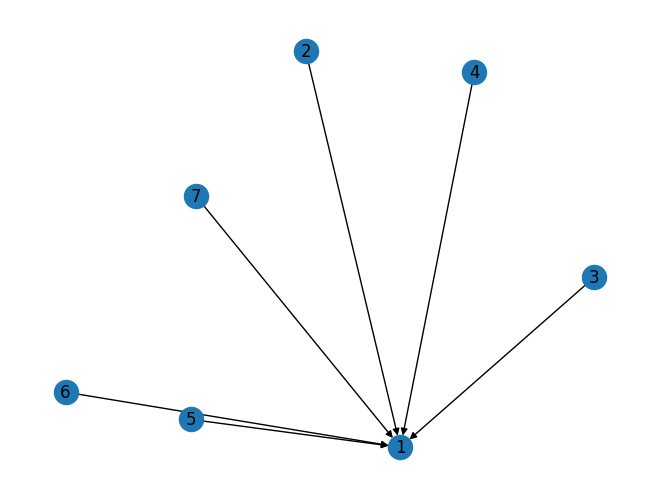

HITS algorithm:
ranking: [2, 1, 3, 4, 5, 6, 7]
similarity with InDegree: 0
similarity with PageRank: 12

InDegree algorithm:
ranking: [2, 1, 3, 4, 5, 6, 7]
similarity with HITS: 0
similarity with PageRank: 12

PageRank algorithm:
ranking: [1, 7, 2, 3, 4, 5, 6]
similarity with InDegree: 12
similarity with HITS: 12

lasso


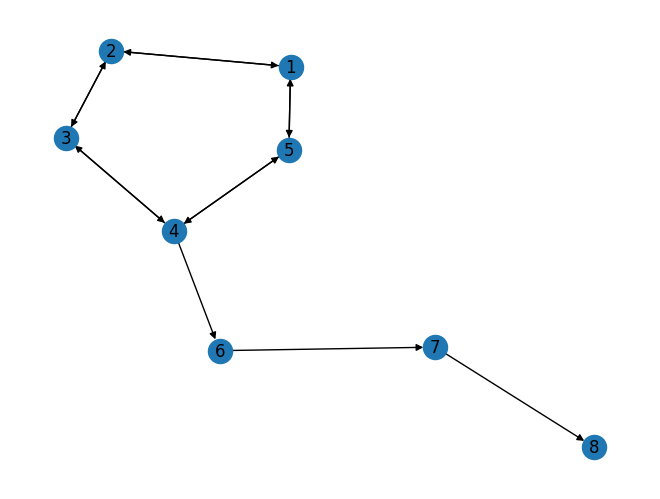

HITS algorithm:
ranking: [4, 5, 2, 1, 3, 6, 7, 8]
similarity with InDegree: 12
similarity with PageRank: 8

InDegree algorithm:
ranking: [1, 2, 3, 4, 5, 6, 7, 8]
similarity with HITS: 12
similarity with PageRank: 10

PageRank algorithm:
ranking: [3, 4, 1, 5, 2, 6, 7, 8]
similarity with InDegree: 10
similarity with HITS: 8

arrow


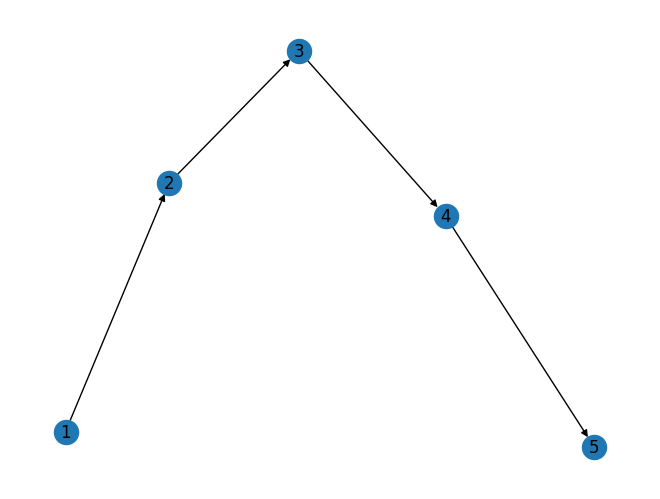

HITS algorithm:
ranking: [4, 1, 2, 3, 5]
similarity with InDegree: 2
similarity with PageRank: 6

InDegree algorithm:
ranking: [5, 1, 2, 3, 4]
similarity with HITS: 2
similarity with PageRank: 8

PageRank algorithm:
ranking: [1, 2, 3, 4, 5]
similarity with InDegree: 8
similarity with HITS: 6

directed_grid


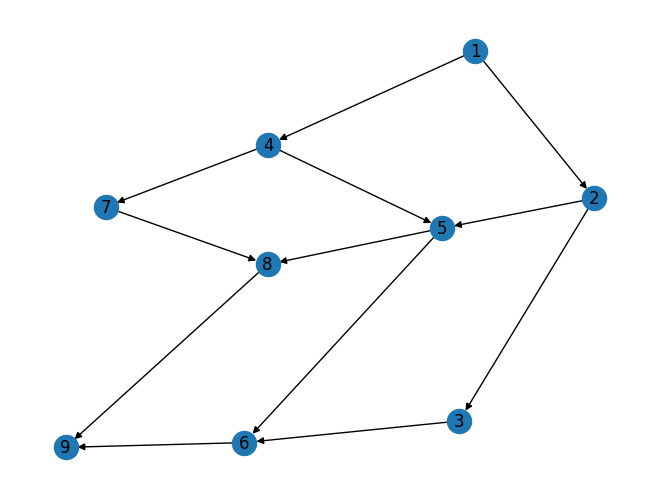

HITS algorithm:
ranking: [9, 6, 7, 2, 1, 4, 3, 5, 8]
similarity with InDegree: 20
similarity with PageRank: 32

InDegree algorithm:
ranking: [9, 5, 6, 7, 1, 2, 8, 3, 4]
similarity with HITS: 20
similarity with PageRank: 36

PageRank algorithm:
ranking: [1, 2, 3, 5, 4, 7, 6, 8, 9]
similarity with InDegree: 36
similarity with HITS: 32



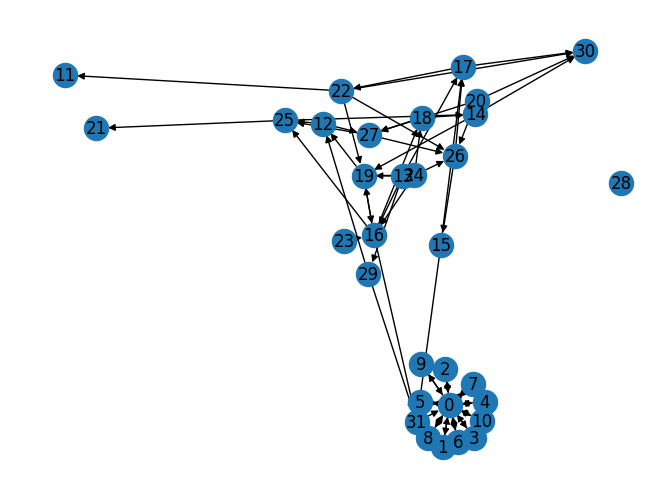

HITS algorithm:
ranking: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 22, 28, 26, 25, 29, 16, 20, 18, 13, 27, 31, 21, 30, 23, 19, 14, 17, 32, 24, 15, 12]
similarity with InDegree: 262
similarity with PageRank: 120

InDegree algorithm:
ranking: [1, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 10, 29, 11, 24, 2, 6, 12, 3, 30, 25, 26, 31, 27, 7, 4, 8, 32, 28, 5, 9]
similarity with HITS: 262
similarity with PageRank: 356

PageRank algorithm:
ranking: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 29, 27, 13, 22, 17, 14, 25, 23, 15, 24, 30, 21, 19, 16, 28, 20, 26, 31, 18, 32, 12]
similarity with InDegree: 356
similarity with HITS: 120



In [ ]:
def compare_algorithms(graph_name):
  if type(graph_name) is str:
    print(graph_name)
    graph = gen_graph(graph_name)
  else:
    graph = graph_name
    nx.draw(graph, with_labels=True)
    plt.show()


  #Get ranking of Hits algorithm
  adjacency_matrix = nx.to_numpy_array(graph)
  rank_hits = hits(adjacency_matrix, k=20)

  #Get ranking of indegree algorithm
  rank_indegree = indegree(graph)

  #Get ranking of PageRank
  rank_page_rank = page_rank(adjacency_matrix)

  print("HITS algorithm:\nranking: " + str(rank_hits) + "\nsimilarity with InDegree: " + str(calc_distance(rank_hits, rank_indegree)) + "\nsimilarity with PageRank: " + str(calc_distance(rank_hits, rank_page_rank)) + "\n")
  print("InDegree algorithm:\nranking: " + str(rank_indegree) + "\nsimilarity with HITS: " + str(calc_distance(rank_indegree, rank_hits)) + "\nsimilarity with PageRank: " + str(calc_distance(rank_indegree, rank_page_rank)) + "\n")
  print("PageRank algorithm:\nranking: " + str(rank_page_rank) + "\nsimilarity with InDegree: " + str(calc_distance(rank_indegree, rank_page_rank)) + "\nsimilarity with HITS: " + str(calc_distance(rank_page_rank, rank_hits)) + "\n")

compare_algorithms("inward_star")
compare_algorithms("lasso")
compare_algorithms("arrow")
compare_algorithms("directed_grid")
matrix = gen_spam_matrix(10,20)
graph = nx.DiGraph(matrix)
compare_algorithms(graph)